In [1]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import os

In [ ]:
# read Data Lorenzo
# drive.mount("/content/drive")
# os.chdir("drive/My Drive/data")
# df = pd.read_csv('ble_data.csv')

KeyboardInterrupt: ignored

In [12]:
# Read data Vera
# Mount data from drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/My Drive/ishango/dance/data/ble_data.csv")
df.head(n=5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,vehicle_id,user_id,total_mileage,versions_mc_firmware,occurred_at_time,app_version,assist_level,battery_cells,battery_error_state,battery_serial_number,...,battery_state_real_time_current,battery_state_remaining_capacity,dance_area,event,hmi_serial_number,os_name,remaining_mileage,versions_battery_firmware,versions_hmi_firmware,versions_hmi_hardware
0,bc3412f7-37a8-4676-8043-53f4a1bb316a,ca73adbe-5930-45ba-af74-de5865d8b093,7281.0,DA210815.10,2023-04-05 08:54:50,2023.03.24-3923-prod-release,0.0,"[null,null,null,null,null,null,null,null,null,...",0.0,HT1002MA121521183,...,-60.0,0.0,PARIS,Vehicle Connected,60968A,Android,1300.0,0.3.3.0,1.7.18.0,1.0
1,95e7ee01-3987-481a-9000-3b331c52192f,6560e385-b90d-42be-b977-5cdb3a5d5a60,NaN,NaN,2022-09-05 18:13:47,2022.8.26,NaN,NaN,0.0,NaN,...,NaN,NaN,PARIS,Vehicle Connected,NaN,iOS,NaN,NaN,NaN,NaN
2,c63d60f2-5e2a-483c-bb11-935c45ebf2f0,118047dc-bf44-4dc0-9862-0cb3ac5db65d,1185.0,DA210815.10,2023-09-10 12:22:06,2023.9.4,1.0,NaN,0.0,NaN,...,-30.0,NaN,BERLIN,Vehicle Connected,2C139F,iOS,712.0,0.3.3.0,1.7.18.0,1.0
3,79df825d-8115-4a84-9aa8-87ae307ae561,f0c0ac6d-32a1-45ed-9de1-466455fa637a,378.0,DA210815.10,2022-09-14 07:50:05,2022.08.30-3095-prod-release,2.0,"[3997,3997,4001,3994,4000,4013,4014,4015,4009,...",0.0,HT1002MA121251821,...,-107.0,7479.0,BERLIN,Vehicle Connected,73D58B,Android,474.0,1.0.6.0,1.7.28.0,1.0
4,0d30c889-a102-4bdc-b8a3-c1e0d6c536d5,2b9f8b3f-b3f3-409b-ade0-dd9ae8b54ba7,NaN,NaN,2022-09-12 14:12:19,2022.8.29,NaN,NaN,0.0,4854313030324d41313231353231373236000000,...,NaN,NaN,HAMBURG,Vehicle Connected,NaN,iOS,NaN,NaN,NaN,NaN


In [ ]:
df['user_id'].nunique()

9139

In [13]:
## data cleaning

# remove duplicates
df = df.drop_duplicates()

# drop NAs in mileage
df = df.dropna(subset=['total_mileage'])

# sort based on time
df = df.sort_values(by='occurred_at_time')

# adjust datatype
df['occurred_at_time'] = pd.to_datetime(df['occurred_at_time'])

# drop all records with total_mileage above 30000 and 0
df = df[df['total_mileage'] < 30000]
df = df[df['total_mileage'] != 0]

print(df.shape[0])

2660738


In [15]:
## clean battery serial number -> valid numbers are 17 characters starting with 'HT' (e.g HT1002MA121220310)

print("Number of null values in battery before cleaning:", df['battery_serial_number'].isnull().sum())

# substring 17 characters
df['battery_serial_number_clean'] = df['battery_serial_number'].str[:17].astype(str)

# keep rows starting with 'HT' otherwise set to none and length 17
df['battery_serial_number_clean'] = df['battery_serial_number_clean'].apply(lambda x: x if ((x.startswith('HT')) & (len(x)== 17)) else None)

# remove rows where we only have 5 battery records per vehicle (seem to be wrong recordings)
df['combination_count'] = df.groupby(['vehicle_id', 'battery_serial_number_clean'])['vehicle_id'].transform('size')

mask = (df['combination_count'].isnull()) | (df['combination_count'] > 5)
df = df[mask]

print("Number of null values in battery after cleaning:", df['battery_serial_number_clean'].isnull().sum())

Number of null values in battery before cleaning: 307507
Number of null values in battery after cleaning: 940975


In [26]:
# fill empty battery numbers with closest none null for each bike
example = df[df['vehicle_id'] == '598c35a4-0510-4178-a973-d568f51f8085'] #'00214cc8-4fc8-4dab-b5a8-4b9063f145ec']
print('Batteries before filling: \n\n', example['battery_serial_number_clean'].value_counts(dropna=False))

example['Battery_Count'] = example.groupby('vehicle_id')['battery_serial_number_clean'].transform('count')
print('Batteries before filling: \n\n', example['Battery_Count'].value_counts(dropna=False))

# Example many batteries but probably wrong: '018da913-cb68-4868-bd57-72fb3ecb756b'

# Sort the DataFrame by 'Bike' and 'Timestamp'
example = example.sort_values(['vehicle_id', 'occurred_at_time'])
example['battery_filled'] = example['battery_serial_number_clean']

def interpolate_string(group):
    group['battery_filled'].fillna(method='ffill', inplace=True)
    group['battery_filled'].fillna(method='bfill', inplace=True)
    return group

# Apply the custom interpolation function to each group
example = example.groupby('vehicle_id', group_keys=False).apply(interpolate_string).reset_index(drop=True)

print('Batteries after filling: \n\n', example['battery_filled'].value_counts(dropna=False))

Batteries before filling: 

 HT1002MA121402019    422
None                 127
HT1002MA121340191    121
HT1002MA122261219    104
HT1002MA121520034     40
HT1002MA122440146     22
HT1002MA122440892     16
Name: battery_serial_number_clean, dtype: int64
Batteries before filling: 

 725    852
Name: Battery_Count, dtype: int64
Batteries after filling: 

 HT1002MA121402019    549
HT1002MA121340191    121
HT1002MA122261219    104
HT1002MA121520034     40
HT1002MA122440146     22
HT1002MA122440892     16
Name: battery_filled, dtype: int64


<ipython-input-26-2bbd66851284>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example['Battery_Count'] = example.groupby('vehicle_id')['battery_serial_number_clean'].transform('count')


<ipython-input-27-837360639063>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20', len(unique_group_types))
<ipython-input-27-837360639063>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20', len(unique_group_types))


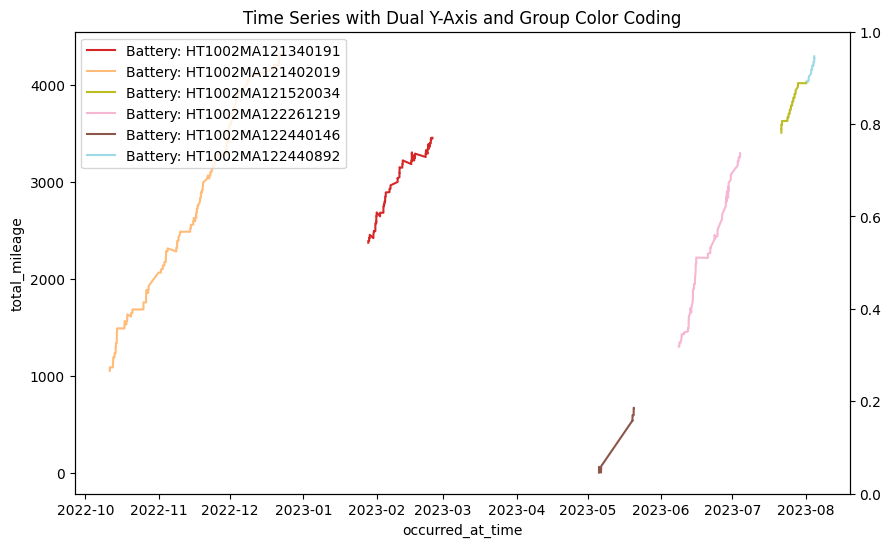

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Create a figure and two subplots sharing the same x-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Get unique values in the 'group_type' column
unique_group_types = example['battery_serial_number_clean'].unique()

# Generate a color map based on the number of unique values
cmap = get_cmap('tab20', len(unique_group_types))

# Generate a color map based on the number of unique values
cmap = get_cmap('tab20', len(unique_group_types))

# Create a color mapping dictionary
color_map = {group_type: cmap(i) for i, group_type in enumerate(unique_group_types)}

for group_type, group_df in example.groupby('battery_serial_number_clean'):
    ax1.plot(group_df['occurred_at_time'], group_df['total_mileage'], color=color_map[group_type], label=f'Battery: {group_type}')


ax1.set_xlabel('occurred_at_time')
ax1.set_ylabel('total_mileage')
ax1.tick_params(axis='y')

# Create a twin y-axis on the right side
ax2 = ax1.twinx()

# Add legends
lines, labels = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines , labels, loc='upper left')

# Show the plot
plt.title('Time Series with Dual Y-Axis and Group Color Coding')
plt.show()


<ipython-input-28-6aa813c4c7a6>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20', len(unique_group_types))
<ipython-input-28-6aa813c4c7a6>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20', len(unique_group_types))


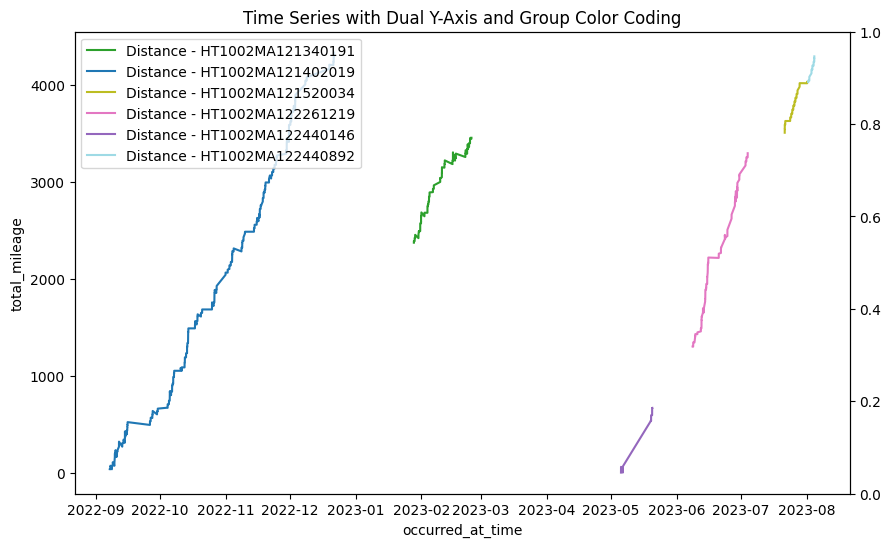

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Create a figure and two subplots sharing the same x-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Get unique values in the 'group_type' column
unique_group_types = example['battery_filled'].unique()

# Generate a color map based on the number of unique values
cmap = get_cmap('tab20', len(unique_group_types))

# Generate a color map based on the number of unique values
cmap = get_cmap('tab20', len(unique_group_types))

# Create a color mapping dictionary
color_map = {group_type: cmap(i) for i, group_type in enumerate(unique_group_types)}

for group_type, group_df in example.groupby('battery_filled'):
    ax1.plot(group_df['occurred_at_time'], group_df['total_mileage'], color=color_map[group_type], label=f'Distance - {group_type}')


ax1.set_xlabel('occurred_at_time')
ax1.set_ylabel('total_mileage')
ax1.tick_params(axis='y')

# Create a twin y-axis on the right side
ax2 = ax1.twinx()

# Add legends
lines, labels = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines , labels, loc='upper left')

# Show the plot
plt.title('Time Series with Dual Y-Axis and Group Color Coding')
plt.show()


In [ ]:
example['Combination Count'] = example.groupby(['vehicle_id', 'battery_filled'])['vehicle_id'].transform('size')
example['Combination Count'].unique()
example = example[example['Combination Count'] > 5]
example['Combination Count'].unique()

<ipython-input-157-5cab2ebcf619>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example['Combination Count'] = example.groupby(['vehicle_id', 'battery_filled'])['vehicle_id'].transform('size')


array([441,  72])

In [ ]:
example = df[df['vehicle_id'] == 'f6e9da63-5a8d-4c87-a155-e10a0032aafd']

df['battery_serial_number_clean'].unique()

array(['HT1002MA121220310', 'HT1002MA121220302', None, ...,
       'HT1002MA12223020', 'HT1002MA122350120', 'HT1002MA122520934'],
      dtype=object)

In [25]:
# Count the number of batteries per vehicle
unique_battery_counts = df.groupby('vehicle_id')['battery_serial_number_clean'].nunique().reset_index()

unique_battery_counts.sort_values(by='battery_serial_number_clean', ascending=False).head(n=20)


,vehicle_id,battery_serial_number_clean
1735,4132d7c6-9693-45f7-8525-dcafef717148,14
3630,86f10c5e-b84c-495f-8b0a-0c2d3539d9a7,10
3534,831f37ba-c02f-4418-81bc-6531bbbd84a3,8
4164,9985075f-6731-495d-97ca-45bcfb65329d,8
2721,66ba252d-88b9-4b76-9bbc-30965c3c5826,8
6434,eae24ee5-b526-4196-bc82-7abf0d981468,7
1065,278f1e41-d0d5-4c19-9b87-72b1531e252c,7
882,20431462-11dd-4cfa-8bee-1f4077ee8a51,7
843,1eab881b-e7db-46ba-bc23-ded0fbc99f94,7
1615,3c527b5f-aadd-4cce-8636-d621d8eac6ce,7


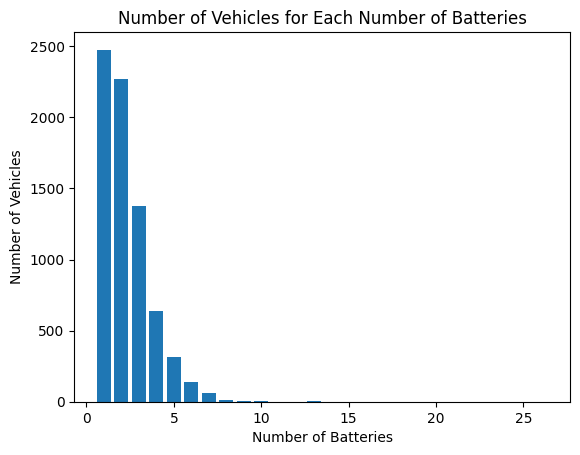

In [ ]:
# Count the number of vehicles for each unique 'BatteryCount' value
vehicle_counts = unique_battery_counts.groupby('battery_serial_number_clean')['vehicle_id'].nunique()

# Create a bar chart
plt.bar(vehicle_counts.index, vehicle_counts.values)
plt.title('Number of Vehicles for Each Number of Batteries')
plt.xlabel('Number of Batteries')
plt.ylabel('Number of Vehicles')

# Show the chart
plt.show()

In [ ]:
# bikes per battery
unique_vehicles_counts = df.groupby('battery_serial_number_clean')['vehicle_id'].nunique().reset_index()

unique_vehicles_counts.head(n=6)


,battery_serial_number_clean,vehicle_id
0,HT1002MA00,1
1,HT1002MA121180010,1
2,HT1002MA121180011,1
3,HT1002MA121180014,1
4,HT1002MA121180017,2
5,HT1002MA121180027,2


In [ ]:
# Count the number of batteries for each unique 'VehicleCount' value
vehicle_counts = unique_vehicles_counts.groupby('vehicle_id')['battery_serial_number_clean'].nunique()
vehicle_counts

vehicle_id
1       5698
2       1821
3        605
4        176
5         50
6         19
7          5
8          2
11         1
16         1
17         1
19         2
24         1
32         1
38         1
4408       1
Name: battery_serial_number_clean, dtype: int64

In [ ]:
# show how many rows are null:
null_counts = df['batter_serial_number_clean'].isnull().sum()
print(null_counts)

df_cleaned = df['batter_serial_number_clean'].dropna()

# Count the number of rows in the cleaned DataFrame
print(len(df_cleaned))
print(len(df))

310491
2377316
2687807


In [ ]:
# Minimum total_milage
result_min = df.groupby('vehicle_id')['total_mileage'].agg(min_distance='min').reset_index()
result_min.head(30)

,vehicle_id,min_distance
0,0000a2c8-03b6-4b57-a74b-851cb77c598d,0.0
1,0015759e-40c9-4094-8540-6378f7c951f2,0.0
2,00201fbf-764d-43ba-8430-e51ac2293794,5.0
3,00214cc8-4fc8-4dab-b5a8-4b9063f145ec,58.0
4,002e111e-8ae5-49d1-a0f1-5f4ce5c479f3,513.0
5,003c3bdc-53fd-4889-acdf-f2840cf9218b,4471.0
6,00400596-6e6a-4382-bb1a-01ca30b3fb3f,5.0
7,005022ad-645d-4865-8a12-c279e0a41dd7,494.0
8,0051e363-1360-4ce9-972e-f473d9f60d56,158.0
9,0060548b-8471-445a-ae1d-69a626ae0b83,9703.0


In [ ]:
result_min.shape

(7308, 2)

In [ ]:
df.columns

Index(['vehicle_id', 'user_id', 'total_mileage', 'versions_mc_firmware',
       'occurred_at_time', 'app_version', 'assist_level', 'battery_cells',
       'battery_error_state', 'battery_serial_number',
       'battery_state_battery_soc', 'battery_state_battery_soh',
       'battery_state_cell_temp_1', 'battery_state_cell_temp_2',
       'battery_state_chg_temp', 'battery_state_dsg_temp',
       'battery_state_full_capacity', 'battery_state_pack_voltage',
       'battery_state_pre_start_temp', 'battery_state_real_time_current',
       'battery_state_remaining_capacity', 'dance_area', 'event',
       'hmi_serial_number', 'os_name', 'remaining_mileage',
       'versions_battery_firmware', 'versions_hmi_firmware',
       'versions_hmi_hardware'],
      dtype='object')

In [ ]:
print(df[df['vehicle_id']=='00e10c80-c79a-4e5e-b5ee-73de58bb7091'].head(3))

                                   vehicle_id  \
1041371  00e10c80-c79a-4e5e-b5ee-73de58bb7091   
1885347  00e10c80-c79a-4e5e-b5ee-73de58bb7091   
747664   00e10c80-c79a-4e5e-b5ee-73de58bb7091   

                                      user_id  total_mileage  \
1041371  b4db375f-623d-49a4-b4c9-9d724f8960a9         6622.0   
1885347  b4db375f-623d-49a4-b4c9-9d724f8960a9         6622.0   
747664   b4db375f-623d-49a4-b4c9-9d724f8960a9         6622.0   

        versions_mc_firmware    occurred_at_time app_version  assist_level  \
1041371          DA210815.10 2022-11-23 12:42:03  2022.11.21           2.0   
1885347          DA210815.10 2022-11-23 12:43:01  2022.11.21           2.0   
747664           DA210815.10 2022-11-23 12:44:02  2022.11.21           2.0   

        battery_cells  battery_error_state battery_serial_number  ...  \
1041371           NaN                  0.0  2VHT02401P02-P4BR522  ...   
1885347           NaN                  0.0  2VHT02401P02-P4BR522  ...   
747664        

In [ ]:
result_min[result_min['min_distance']<500].shape

(5151, 2)

<ipython-input-20-43776859b7cb>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20', len(unique_group_types))
<ipython-input-20-43776859b7cb>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20', len(unique_group_types))


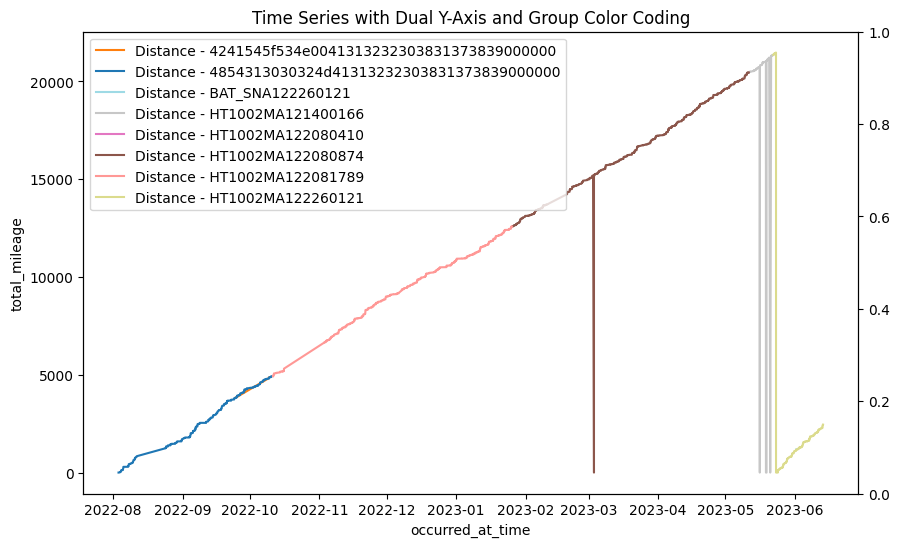

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Sample DataFrame
df = df[df['vehicle_id'] == '382d4727-6119-4391-adc0-ac5500c489b6']


# Create a figure and two subplots sharing the same x-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Get unique values in the 'group_type' column
unique_group_types = df['battery_serial_number'].unique()

# Generate a color map based on the number of unique values
cmap = get_cmap('tab20', len(unique_group_types))

# Generate a color map based on the number of unique values
cmap = get_cmap('tab20', len(unique_group_types))

# Create a color mapping dictionary
color_map = {group_type: cmap(i) for i, group_type in enumerate(unique_group_types)}

for group_type, group_df in df.groupby('battery_serial_number'):
    ax1.plot(group_df['occurred_at_time'], group_df['total_mileage'], color=color_map[group_type], label=f'Distance - {group_type}')


ax1.set_xlabel('occurred_at_time')
ax1.set_ylabel('total_mileage')
ax1.tick_params(axis='y')

# Create a twin y-axis on the right side
ax2 = ax1.twinx()

# # Plot the 'money' data on the right y-axis (ax2) with color mapping
# for group_type, group_df in df.groupby('group_type'):
#     ax2.plot(group_df['date'], group_df['money'], color=color_map[group_type], label=f'Money - {group_type}')

# ax2.set_ylabel('Money')
# ax2.tick_params(axis='y')

# Add legends
lines, labels = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines , labels, loc='upper left')

# Show the plot
plt.title('Time Series with Dual Y-Axis and Group Color Coding')
plt.show()


In [ ]:
df['battery_serial_number'].drop_duplicates()

833109     4854313030324d41313232303831373839000000
895774     4241545f534e0041313232303831373839000000
812517                                          NaN
1386119                           HT1002MA122081789
2387855                           HT1002MA122080874
1204978                           HT1002MA122080410
23627                             HT1002MA121400166
1534757                           HT1002MA122260121
670114                             BAT_SNA122260121
Name: battery_serial_number, dtype: object

**Plots for some examplary 🚴:**



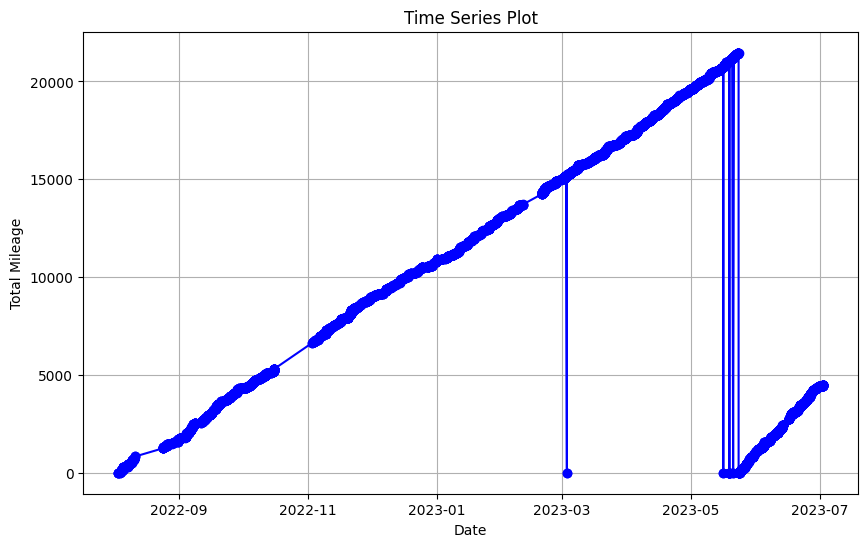

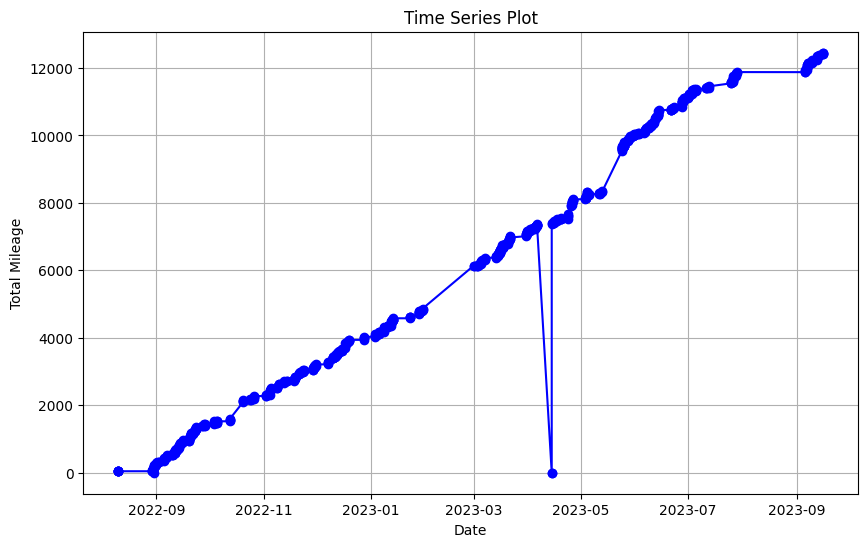

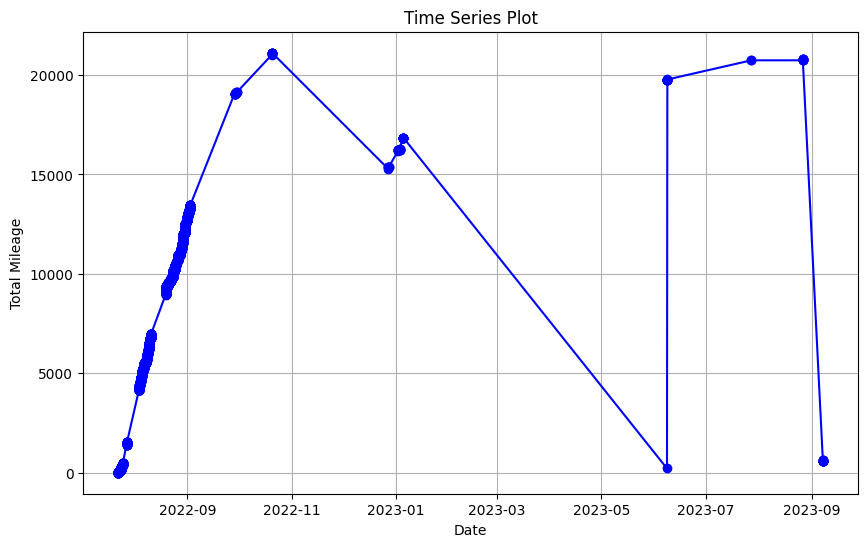

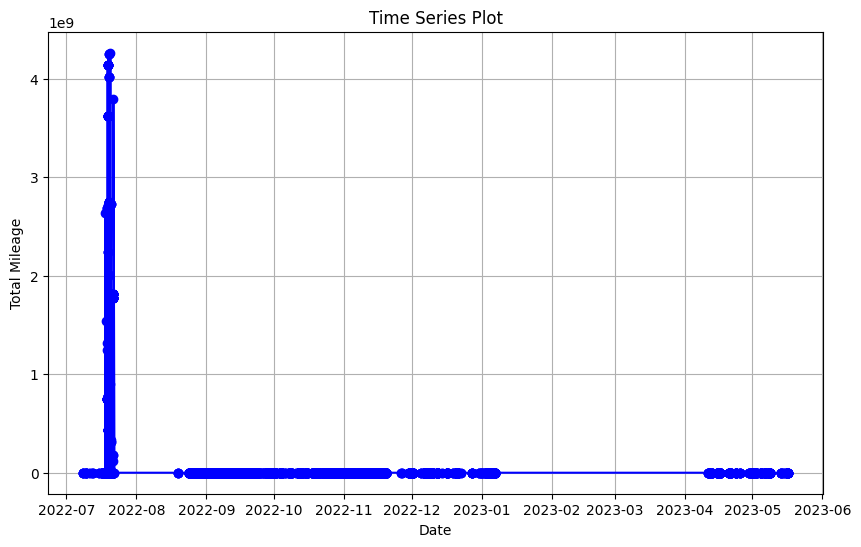

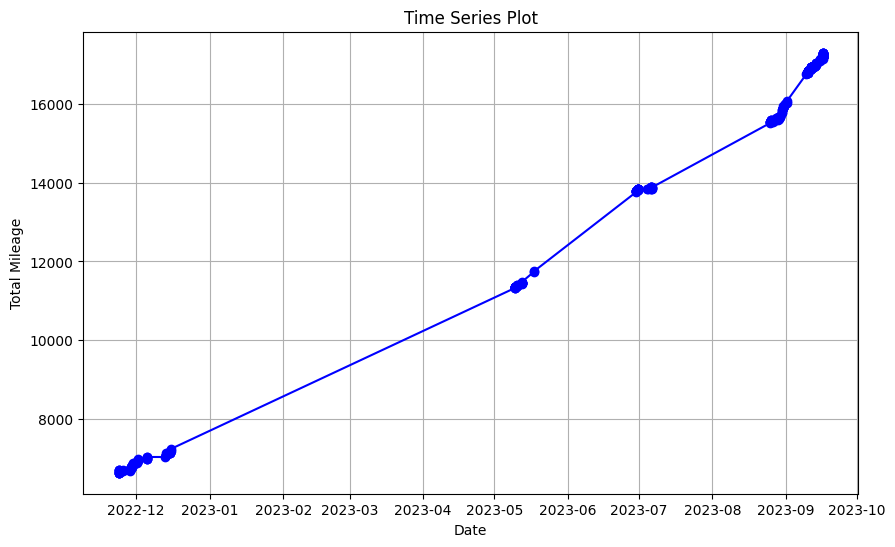

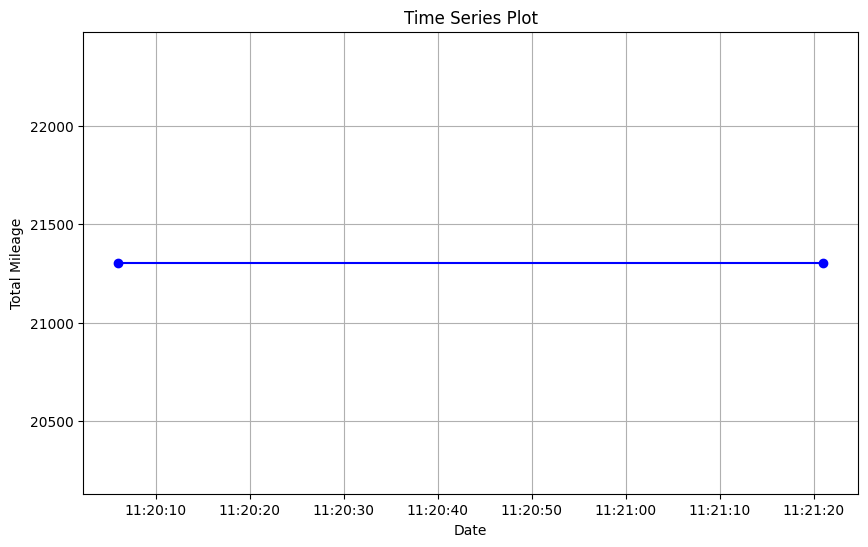

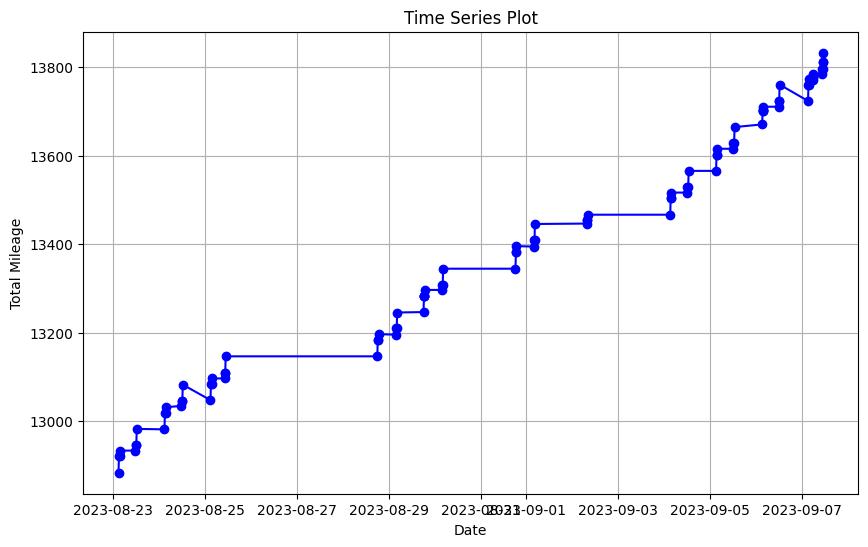

In [ ]:
# vehicles
vehicles = ['382d4727-6119-4391-adc0-ac5500c489b6',
            'bc3412f7-37a8-4676-8043-53f4a1bb316a',
            'ca4c5d0d-0d08-4189-b8ee-e8cd4d337422',
            '4cf2b02f-5631-4441-a93d-a1f2d59c83bf',
            '00e10c80-c79a-4e5e-b5ee-73de58bb7091',
            '010df9b5-ecea-445a-9cc5-01fa71edcce3',
            '00c8acbf-39fe-44dc-bdc5-257e189c4a58'
            ]

for vehicle in vehicles:
  df_interim = df[df['vehicle_id'] == vehicle]

  # plot mileage vs time:a
  df_interim.set_index('occurred_at_time', inplace=True)
  plt.figure(figsize=(10, 6))
  plt.plot(df_interim.index, df_interim['total_mileage'], marker='o', linestyle='-', color='b')
  plt.title('Time Series Plot')
  plt.xlabel('Date')
  plt.ylabel('Total Mileage')
  plt.grid(True)
  plt.show()

In [ ]:
# based on above observation, it seems that there is a reset after total mileage of around 22000 (2200 km)
# TODO: filter out everything above 30000 km to avoid massive outliers in mileage
# TODO: in the first two graphs you see some random outliers with 0, try to find a way to filter them out
# TODO: for our analysis, we should not have this reset to 0 after 2200 km, as it seems like there is e.g. a new battery.
#       Ideally, we find a way that the time series keeps increasing and the values are basically added up. E.g. for the first graph after June '23
#       the values should keep increasing and not restart from 0.
#       Keep in mind that those resets happen several times, so we should find a smart solution here.